---
title: Introduction to ML Fundamentals & sklearn
description: >
  This notebook contains solutions to the exercises of the Advanced Python workshop.
  It is part of the Data Science Training Materials at MPIA.
authors:
- name: Morgan Fouesneau
  orcid: 0000-0001-9256-5516
  affiliation: mpia
- name: Iva Momcheva
  affiliation: mpia
affiliations:
    - id: mpia
      institution: Max Planck Institute for Astronomy, Königstuhl 17, 69117 Heidelberg, Germany 
      ror: https://ror.org/01vhnrs90
      isni: 0000 0004 0491 677X
      department: Data Science Department
      address: Königstuhl 17
      city: Heidelberg
      country: Germany
      postal_code: 69117
date: 2024-06-24
---

+++ {part: abstract}
This Notebook is part of the Workshop we gave at MPIA to introduce machine learning.
+++

## Setup project environement

First, we define a virtual environment for our project. This is a good practice to avoid conflicts between different projects.
Details on how to create a virtual environment can be found on our FAQ [here](https://mpi-astronomy.github.io/FAQ/chapters/python/virtualenv.html)

Once done, we can activate the environment and install the required packages. We will use the following packages (for both days):

In [1]:
%%file requirements.txt

matplotlib
pandas
numpy
scikit-learn
torch
astropy
shap
tqdm
ipywidgets
requests

Overwriting requirements.txt


You can install the packages using the following command (after activating your virtual environment):
```bash
python3 -m pip install -q -r requirements.txt
```

## Setup notebook

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
# The following is only for the presentation, you can ignore it
from IPython.display import Markdown, display
plt.style.use('fivethirtyeight')
# to keep everything reproducible
np.random.seed(2024)

##  Introduction

In this notebook, we will introduce the basic concepts of machine learning and how to use Python to perform simple machine learning tasks.

This year, we will define concept throughout the entire workshop. We will start with the basic concepts and build on them as we go along.

### Our project: Predicting galaxy redshift via regression on 3D-HST photometry

We will explore a typical machine learning problem: predicting galaxy redshifts from photometry. We will use the 3D-HST survey photometry to predict the redshift of galaxies. 

The 3D-HST survey is a Hubble Space Telescope Treasury program that has used 248 orbits of HST time to image four fields in the sky with grism spectroscopy (AEGIS, COSMOS, GOODS-S, UKIDSS-UDS). See [Brammer et al., 2012](http://adsabs.harvard.edu/abs/2012ApJ...758L..17B) and the [3D-HST website](https://3dhst.research.yale.edu/Home.html) for more information.

The data we will use is a subset of the 3D-HST photometry and redshifts. We will use the photometry in the F125W, F140W, F160W, F606W, F814W filters, and the redshifts from the 3D-HST catalog from [Skelton et al (2014)](https://dx.doi.org/10.1088/0067-0049/214/2/24).

**Reminder Redshift 101**

The redshift of a galaxy is a measure of how much the wavelength of light from the galaxy has been stretched by the expansion of the Universe. The redshift $z$ is defined as 
$$z = (\lambda_{obs} - \lambda_{em}) / \lambda_{em},$$
where $\lambda_{obs}$ is the observed wavelength of light from the galaxy and $\lambda_{em}$ is the wavelength of the light emitted by the galaxy.

Because of the spectrum shifts, an identical source at different redshifts will have a different color through each pair of filters.

In [3]:
from io import BytesIO
import requests
from astropy.io import votable


def get_svo_filter_profile(identifier: str) -> np.array:
    QUERY_URL = "http://svo2.cab.inta-csic.es/theory/fps/fps.php"
    query = {"ID": identifier}
    response = requests.get(QUERY_URL, params=query)
    response.raise_for_status()
    table = votable.parse_single_table(BytesIO(response.content))
    tab = table.to_table()
    return (tab["Wavelength"].to("angstrom").value, tab["Transmission"].data)

/Users/fouesneau/Work/projects/dsg_workshops/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



> **Figure**: Quasar template from [Glikman et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...640..579G/abstract), and passbands from [The SVO Filter Profile Service](http://svo2.cab.inta-csic.es/theory/fps/) ([Rodrigo, C., Solano, E., 2020](https://ui.adsabs.harvard.edu/abs/2020sea..confE.182R/abstract))


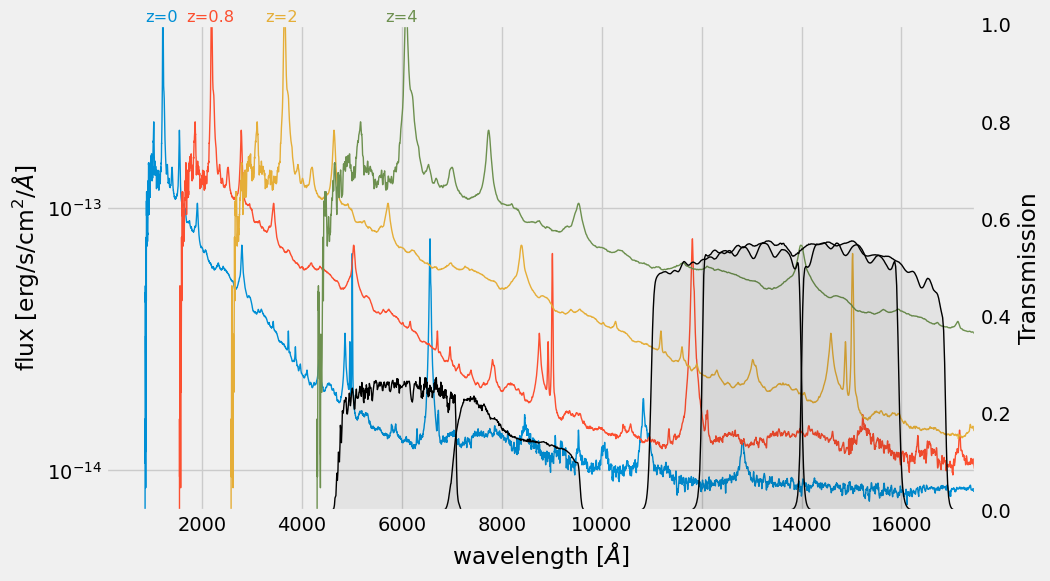

In [4]:
from astropy.io import fits

template_url = "https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/comp_qso/optical_nir_qso_sed_001.fits"
with fits.open(template_url) as hdu:
    wave = hdu[1].data["WAVELENGTH"]
    flux = hdu[1].data["FLUX"]

plt.figure(figsize=(10, 6))

for z in (0, 0.8, 2, 4):
    line_color = plt.semilogy(wave * (1 + z), flux, lw=1)[0].get_color()
    plt.text(
        1_200 * (1 + z),
        5e-13,
        f"z={z}",
        ha="center",
        va="bottom",
        color=line_color,
        fontsize="small",
    )

plt.ylim(7e-15, 5e-13)
plt.xlim(86, 17_500)
plt.xlabel("wavelength [$\AA$]")
plt.ylabel("flux [erg/s/cm$^2$/$\AA$]")

ax = plt.twinx()
which_filters = [
    "HST/ACS_HRC.F606W",
    "HST/ACS_HRC.F814W",
    "HST/WFC3_IR.F125W",
    "HST/WFC3_IR.F140W",
    "HST/WFC3_IR.F160W",
]
for fname in which_filters:
    wave, trans = get_svo_filter_profile(fname)
    ax.plot(wave, trans, color="black", lw=1, label=fname)
    ax.fill_between(wave, trans, color="k", alpha=0.05)
    ax.set_ylim(0, 1)
    ax.grid(False)
ax.set_ylabel("Transmission")

Markdown("""
> **Figure**: Quasar template from [Glikman et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...640..579G/abstract), and passbands from [The SVO Filter Profile Service](http://svo2.cab.inta-csic.es/theory/fps/) ([Rodrigo, C., Solano, E., 2020](https://ui.adsabs.harvard.edu/abs/2020sea..confE.182R/abstract))
""")

### Download the data

First, we download the 3D-HST catalog from the MAST archive. [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24) describe this dataset in details, especially the data selection.

In [5]:
from astropy.utils.data import download_file
import tarfile

file_url = "https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/3dhst_master.phot.v4.1.tar"
tarfile.open(download_file(file_url, cache=True), "r:").extract(
    "3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat", "."
)

Once we have the data on disk, we need to read the combined photmetric catalog. 

Here is the first few lines of the file
```raw
# id field ra dec x y z_spec z_peak faper_F140W eaper_F140W faper_F160W eaper_F160W f_F606W e_F606W f_F814W e_F814W f_F125W e_F125W f_F140W e_F140W f_F160W e_F160W tot_cor kron_radius a_image b_image flux_radius fwhm_image flags f140w_flag star_flag use_phot near_star nexp_f125w nexp_f140w nexp_f160w lmass Av
# By K.E. Whitaker (3/14/2014)
    1.   AEGIS  215.22238159   53.00418472   9590.50   3057.30   -1.0000    0.0100 -8.2041E+01 -8.2041E+01  2.2531E+04  3.9282E-02  1.7906E+03  3.7991E-02  2.8049E+03  5.7433E-02  2.5063E+04  6.0967E-02 -9.9000E+01 -9.9000E+01  2.7188E+04  3.2896E-01    1.0088    3.5000      9.6500      8.8200    2.59E+00    3.4200   0   0   1   0   0   2   0   3    7.51   1.1
    2.   AEGIS  215.09658813   52.91805267  16473.20   3150.20   -1.0000    0.0100  3.5078E+00  7.4233E-02  3.9905E+00  3.7441E-02  9.0928E+01  1.7795E+00  1.4605E+02  2.7091E+00  2.5244E+02  3.0231E+00  2.5959E+02  5.4934E+00  2.9531E+02  1.6266E+00    1.0000    4.0800     31.1300     26.8900    3.81E+01   67.5200   3   0   0   0   0   4   4   4    5.62   0.1
```

Because the catalog is in ASCII format, we can use `astropy` and convert the `Table` into a `pandas.dataframe` object. The latter is more convenient with `sklearn` but cannot directly read the ASCII table (it contains misplaced comments).

```python
from astropy.table import Table

df = Table.read(
    "3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat", format="ascii"
).to_pandas()
```

For completeness, I show below how to directly read the file with `pandas`, but we need to deal with the misplaced comments. 

In [6]:
# read the column header
with open("./3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat") as f:
    header = f.readline().replace("#", "").split()
df = pd.read_csv(
    "./3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat",
    sep="\s+",
    comment="#",
    names=header,
)
df

,id,field,ra,dec,x,y,z_spec,z_peak,faper_F140W,eaper_F140W,...,flags,f140w_flag,star_flag,use_phot,near_star,nexp_f125w,nexp_f140w,nexp_f160w,lmass,Av
0,1.0,AEGIS,215.222382,53.004185,9590.50,3057.30,-1.0000,0.0100,-82.0410,-82.041000,...,0,0,1,0,0,2,0,3,7.51,1.1
1,2.0,AEGIS,215.096588,52.918053,16473.20,3150.20,-1.0000,0.0100,3.5078,0.074233,...,3,0,0,0,0,4,4,4,5.62,0.1
2,3.0,AEGIS,215.161469,52.959461,13060.10,2982.30,-1.0000,0.2062,-1.9043,-1.904300,...,1,0,0,1,0,2,0,2,9.00,1.1
3,4.0,AEGIS,215.305298,53.052921,5422.80,2692.10,-1.0000,0.0355,-72.3250,-72.325000,...,0,0,0,0,0,1,0,1,4.78,0.4
4,5.0,AEGIS,215.041840,52.871273,19894.60,2834.40,-1.0000,0.3427,1890.5000,0.133300,...,0,1,2,0,1,0,3,0,11.57,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207962,44098.0,UDS,34.363106,-5.122067,14578.84,11076.42,-1.0000,0.1852,188.8200,0.170750,...,0,1,2,0,0,0,3,0,10.21,0.2
207963,44099.0,UDS,34.333569,-5.123219,16343.92,11007.12,-1.0000,0.6716,1.7193,0.129080,...,0,1,2,0,0,0,3,0,8.49,0.7
207964,44100.0,UDS,34.363682,-5.123123,14544.39,11013.01,1.4196,2.7489,1.3829,0.113830,...,0,1,2,0,0,0,4,0,9.08,1.4
207965,44101.0,UDS,34.556389,-5.123040,3028.23,11017.04,-1.0000,1.1716,-99.0000,-99.000000,...,1,0,0,0,0,1,0,2,10.55,1.0


### Exploring the dataset

This section aims to examine the contents of the catalog. 

The dataset contains standard information such as target `id`, `field` name, coordinates (`ra`, `dec`), fluxes, uncertainties, and various photometric flags (see [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24) - [Table 10](https://iopscience.iop.org/article/10.1088/0067-0049/214/2/24#apjs499030t10), or download the [README](https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/master_readme.v4.1.txt) here). 

In addition, there are some derived properties such as photometric redshift (`z_peak`), spectroscopic redshift (`z_spec`), mass (`lmass`) and dust extinction in the V band (`Av`).

[Kriek et al (2018; FAST)](https://ui.adsabs.harvard.edu/abs/2018ascl.soft03008K/abstract) describe the mass estimates.

**Keep in mind that we are interested in predicting redshift, so our "target" variable will be `z_spec`. The "features" will be all relevant columns.**

In [7]:
df.columns

Index(['id', 'field', 'ra', 'dec', 'x', 'y', 'z_spec', 'z_peak', 'faper_F140W',
       'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W',
       'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W',
       'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image',
       'flux_radius', 'fwhm_image', 'flags', 'f140w_flag', 'star_flag',
       'use_phot', 'near_star', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w',
       'lmass', 'Av'],
      dtype='object')

We can also get some statistical description

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,207967.0,2.117321e+04,1.265041e+04,1.000000,10399.000000,20797.000000,31195.500000,5.050700e+04
ra,207967.0,1.220675e+02,7.383123e+01,34.216633,53.061646,150.091034,189.306900,2.153053e+02
dec,207967.0,1.446509e+01,3.538768e+01,-27.959742,-5.272032,2.274822,52.957975,6.238830e+01
x,207967.0,1.215648e+04,7.233914e+03,7.400000,7316.685000,10578.100000,15137.135000,3.766890e+04
y,207967.0,1.023374e+04,5.733813e+03,1273.020000,6161.300000,8873.450000,13184.660000,3.075330e+04
z_spec,207967.0,-9.536530e-01,4.891243e-01,-99.900000,-1.000000,-1.000000,-1.000000,6.118000e+00
z_peak,207967.0,1.177393e+00,6.727479e+00,-99.000000,0.817400,1.415900,2.128050,5.960900e+00
faper_F140W,207967.0,-1.542424e+01,3.237767e+02,-482.630000,-48.633500,0.178810,0.491190,4.705200e+04
eaper_F140W,207967.0,-2.211378e+01,5.445781e+01,-482.630000,-48.633500,0.069309,0.086337,1.059200e+04
faper_F160W,207967.0,1.339273e+01,5.961002e+02,-99.000000,0.186090,0.355380,0.939190,9.118500e+04


In the following, we plot the distribution of all the columns.


> Distribution of all the columns in our dataset before feature selection and any preprocessing.


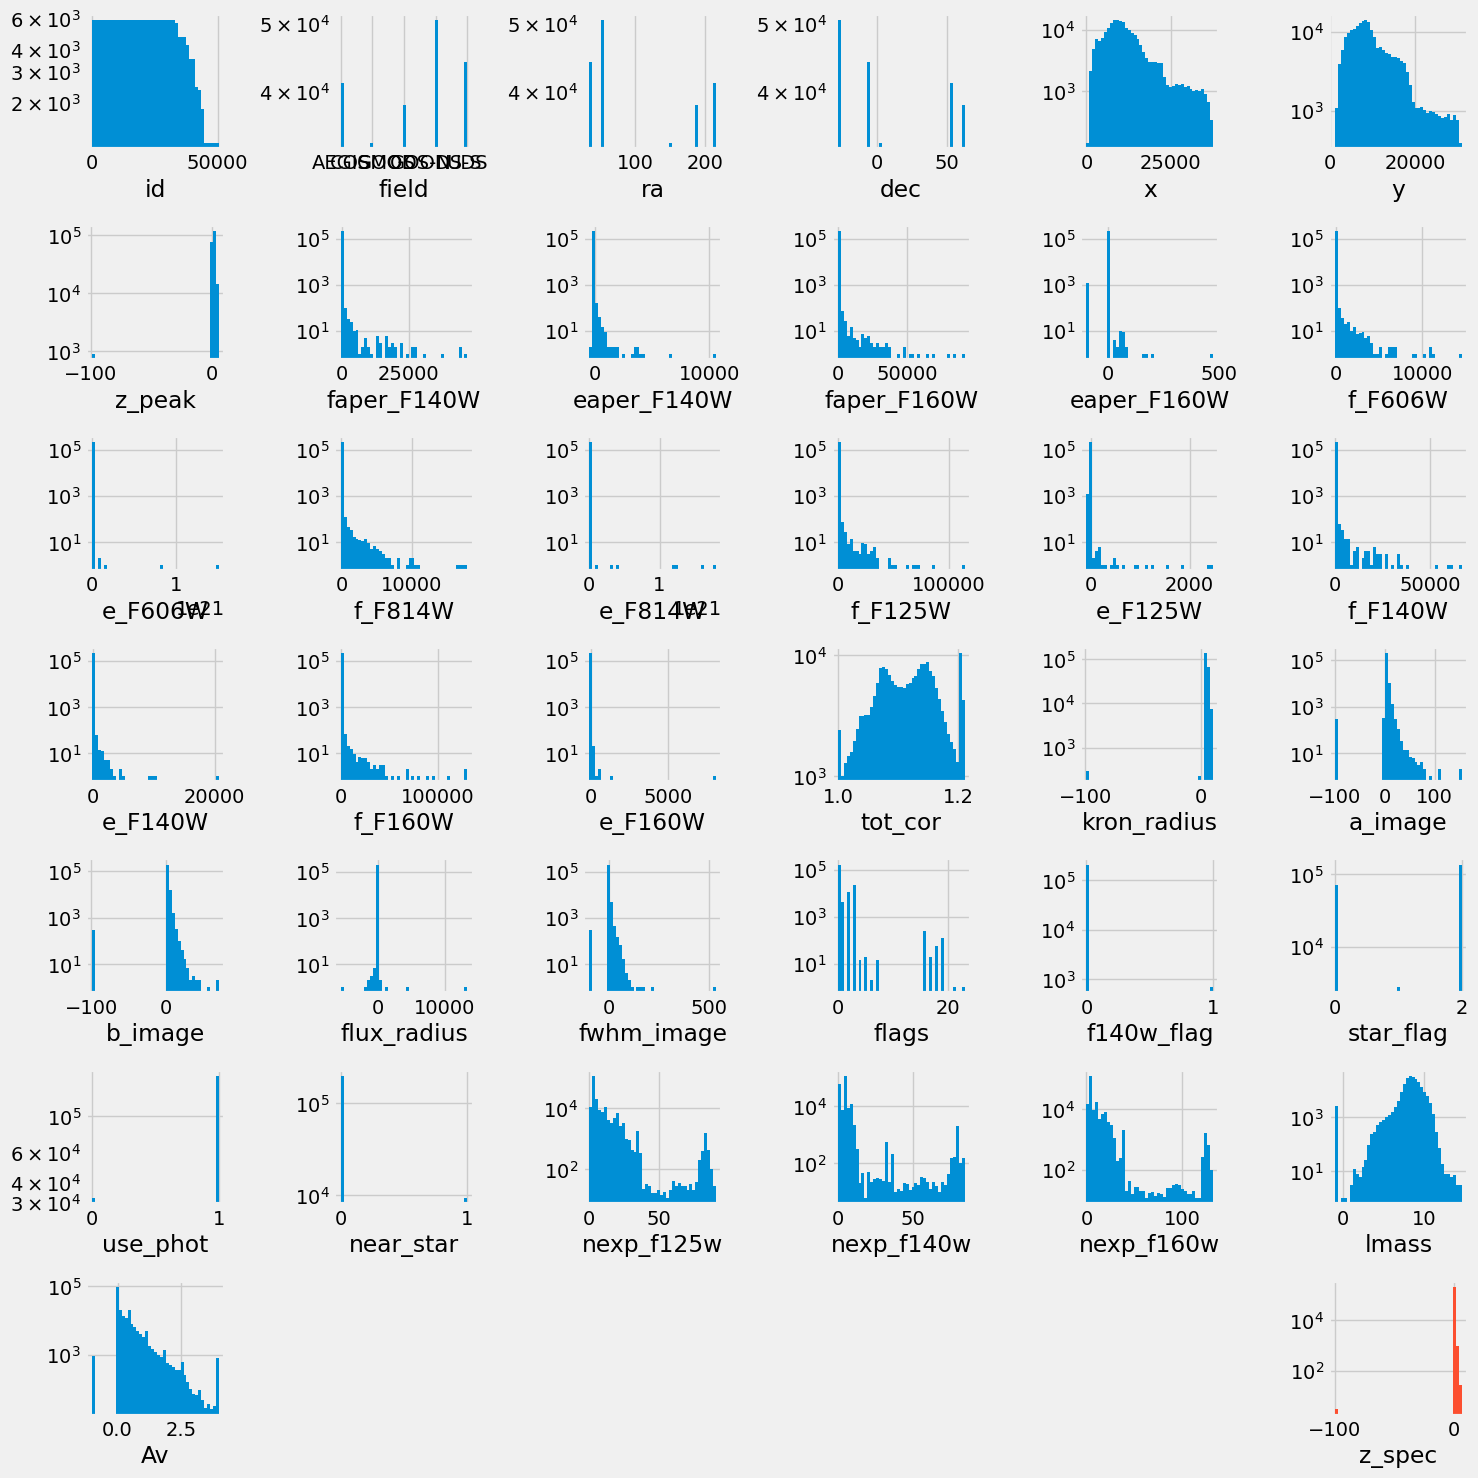

In [9]:
columns = [k for k in df.columns if k != "z_spec"]
wrap = 6  # number of columns to show in a row
nlines = (len(columns) + 1) // wrap + int((len(columns) + 1) % wrap > 0)
fig, axs = plt.subplots(nlines, wrap, figsize=(15, 15))
for i, ax in enumerate(axs.ravel()):
    if i >= len(columns):
        ax.axis("off")
        continue
    ax.hist(df[columns[i]], bins=43, log=True)
    ax.set_xlabel(columns[i])

ax = axs[-1, -1]
ax.axis("on")
plt.hist(df["z_spec"], bins=43, log=True, color="C1")
plt.xlabel("z_spec")
plt.tight_layout()

Markdown("""
> Distribution of all the columns in our dataset before feature selection and any preprocessing.
""")

We are astronomers, we can therefore consider physical relationships between the features. For example, mass vs. redshift


> Physical parameters mass vs. redshift.
We find a pileup of redshit estimates at 0 and even negative estimates. In addition, some
masses are negative. These need to be cleaned for further uses.


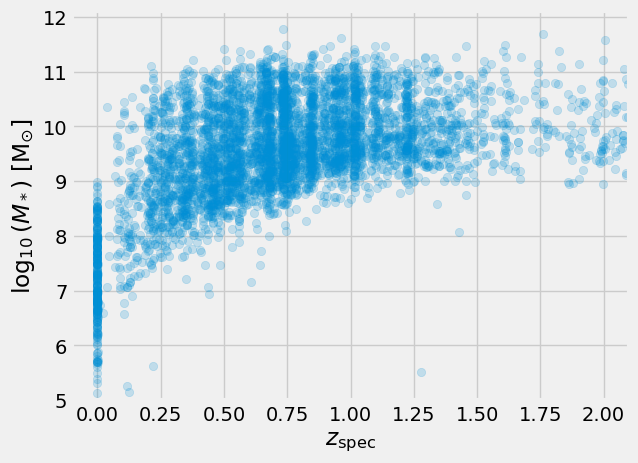

In [10]:
ax = plt.subplot(111)

ax.scatter(df.z_spec, df.lmass, alpha=0.2)
ax.set_xlabel(r"$z_{\rm spec}$")
ax.set_ylabel(r"$\log_{10}{(M_*)}$ [M$_{\odot}$]")
ax.set_xlim(-0.1, 2.1)
ax.set_ylim(5.0, 12.1)
display(
    Markdown("""
> Physical parameters mass vs. redshift.
We find a pileup of redshit estimates at 0 and even negative estimates. In addition, some
masses are negative. These need to be cleaned for further uses.
""")
)

**What do we conclude from this exploration?**

Before building and applying a regression model, we have to deal with
* negative `z_spec` values
* bad values (-99.0) in flux measurements

## Data cleaning, Feature selection, and Data leakage

We need to deal with bad/missing values, and select the features we will use to predict the redshift.


### Feature selection & data leakage

**Definition**: Data leakage is when information about the label takes part into the training dataset to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

For example, if `z_peak`, `lmass` or `z_spec` remain in the training features. Sometimes it could be suddle: for instance including a `MonthlySalary` column when predicting `YearlySalary`; or `MinutesLate` when predicting if a train will be late. 

Data leakage can cause you to create overly optimistic if not completely invalid predictive models.

* We do not keep `z_phot`, `z_peak`, and `lmass` to avoid leakage.
* The `Av`, `lmass` and `z_peak` values come from the FAST photometric fit, and so we will exclude them as well. 
* We will exclude the categorical flag variables (`flags`, `f140w_flag`, `star_flag`, `use_phot`, `near_star`). To first order redshift estimates should be driven by the flux values. We remove the flags to reduce the feature space. We can check if they help later on.

In [11]:
remove = (
    "Av",
    "lmass",
    "z_peak",
    "flags",
    "f140w_flag",
    "star_flag",
    "use_phot",
    "near_star",
    "z_spec",
    "id",
    "field",
    "ra",
    "dec",
    "x",
    "y",
)

# we define the features from the remaining columns and the target is the spectroscopic redshift
features = [col for col in df.columns if col not in remove]
target = "z_spec"

Markdown(f"""
**features** {features}

**target**: {target} """)


**features** ['faper_F140W', 'eaper_F140W', 'faper_F160W', 'eaper_F160W', 'f_F606W', 'e_F606W', 'f_F814W', 'e_F814W', 'f_F125W', 'e_F125W', 'f_F140W', 'e_F140W', 'f_F160W', 'e_F160W', 'tot_cor', 'kron_radius', 'a_image', 'b_image', 'flux_radius', 'fwhm_image', 'nexp_f125w', 'nexp_f140w', 'nexp_f160w']

**target**: z_spec 

### Value filtering and imputing missing values

We need to curate the dataset to remove bad objects and values. Here "bad" remains to be defined. Depending on the features we select, we may need to transform text fields into values/categories.

**Look at the selected data and see if some values are strange, missing, etc. Is there a regime where the redshift will be difficult to learn?**

#### OneHot encoder / categorical values

The example below shows how to proceed. (Note that we did not decide to keep flags in this notebook)

In [12]:
# Using sklearn to encode labels
from sklearn.preprocessing import LabelEncoder
df['field_lbl'] = LabelEncoder().fit_transform(df['field'])

Pandas can also encode the labels into categories (`Categorical` type). This is useful when we have a column with text values that we want to convert into numerical values. 

```python
df['field_lbl] = df['field'].astype('category').cat.codes
```

#### Filtering out / curating the dataset

By inspecting the datset, we find that some filtering is necessary.

* By inspection of mass vs redshift, we will only keep sources with $log(M)>9$ to remove sources that do not have complete coverage across redshift.
* We will also remove redshift value = 0, which likely corresponds to a star.
* And we remove redshift <= 0. Negative values are bad estimates.

In [13]:
# target = z_spec defined above
df = df.loc[(df['lmass'] > 9) & (df[target] > 0)].copy()

**note**:
`df[(df['lmass'] > 9) & (df[target] > 0)]` is a boolean "mask" that selects the rows that satisfy the conditions and creates a view / slice of the initial dataframe. This can lead to issues if we modify the slice. To avoid this, we can use `.copy()` which makes a copy of the slice.

#### Imputing missing values

We need to take care of the missing or bad values.

In linear regression problems, the least informative alteration is to use the median or mean of the distribution. In presence of outliers, median would be more robust.

In the following, we use the median of the distributions to replace bad / missing values, i.e flux mesurements = -99.0.

In [14]:
# inpute missing data in all column names ending with 'W' (e.g. f160w, e_f160w, eaper_f140w, etc.)
ecols = [col for col in features if col.endswith("W")]
ecols

['faper_F140W',
 'eaper_F140W',
 'faper_F160W',
 'eaper_F160W',
 'f_F606W',
 'e_F606W',
 'f_F814W',
 'e_F814W',
 'f_F125W',
 'e_F125W',
 'f_F140W',
 'e_F140W',
 'f_F160W',
 'e_F160W']

In [15]:
for col in ecols:
    missing_value = np.nanmedian(df[col])
    df[col] = df[col].fillna(missing_value)
    df.loc[df[col] < -90, col] = missing_value

### Final dataset

In [16]:
df_x = df[features]
df_y = df[target]

print("The final data set contains {0:,d} samples and {1:,d} features".format(len(df_x), len(df_x.columns)))

The final data set contains 4,173 samples and 23 features



> Distribution of all the feature columns we selected and the target (red) after preprocessing.


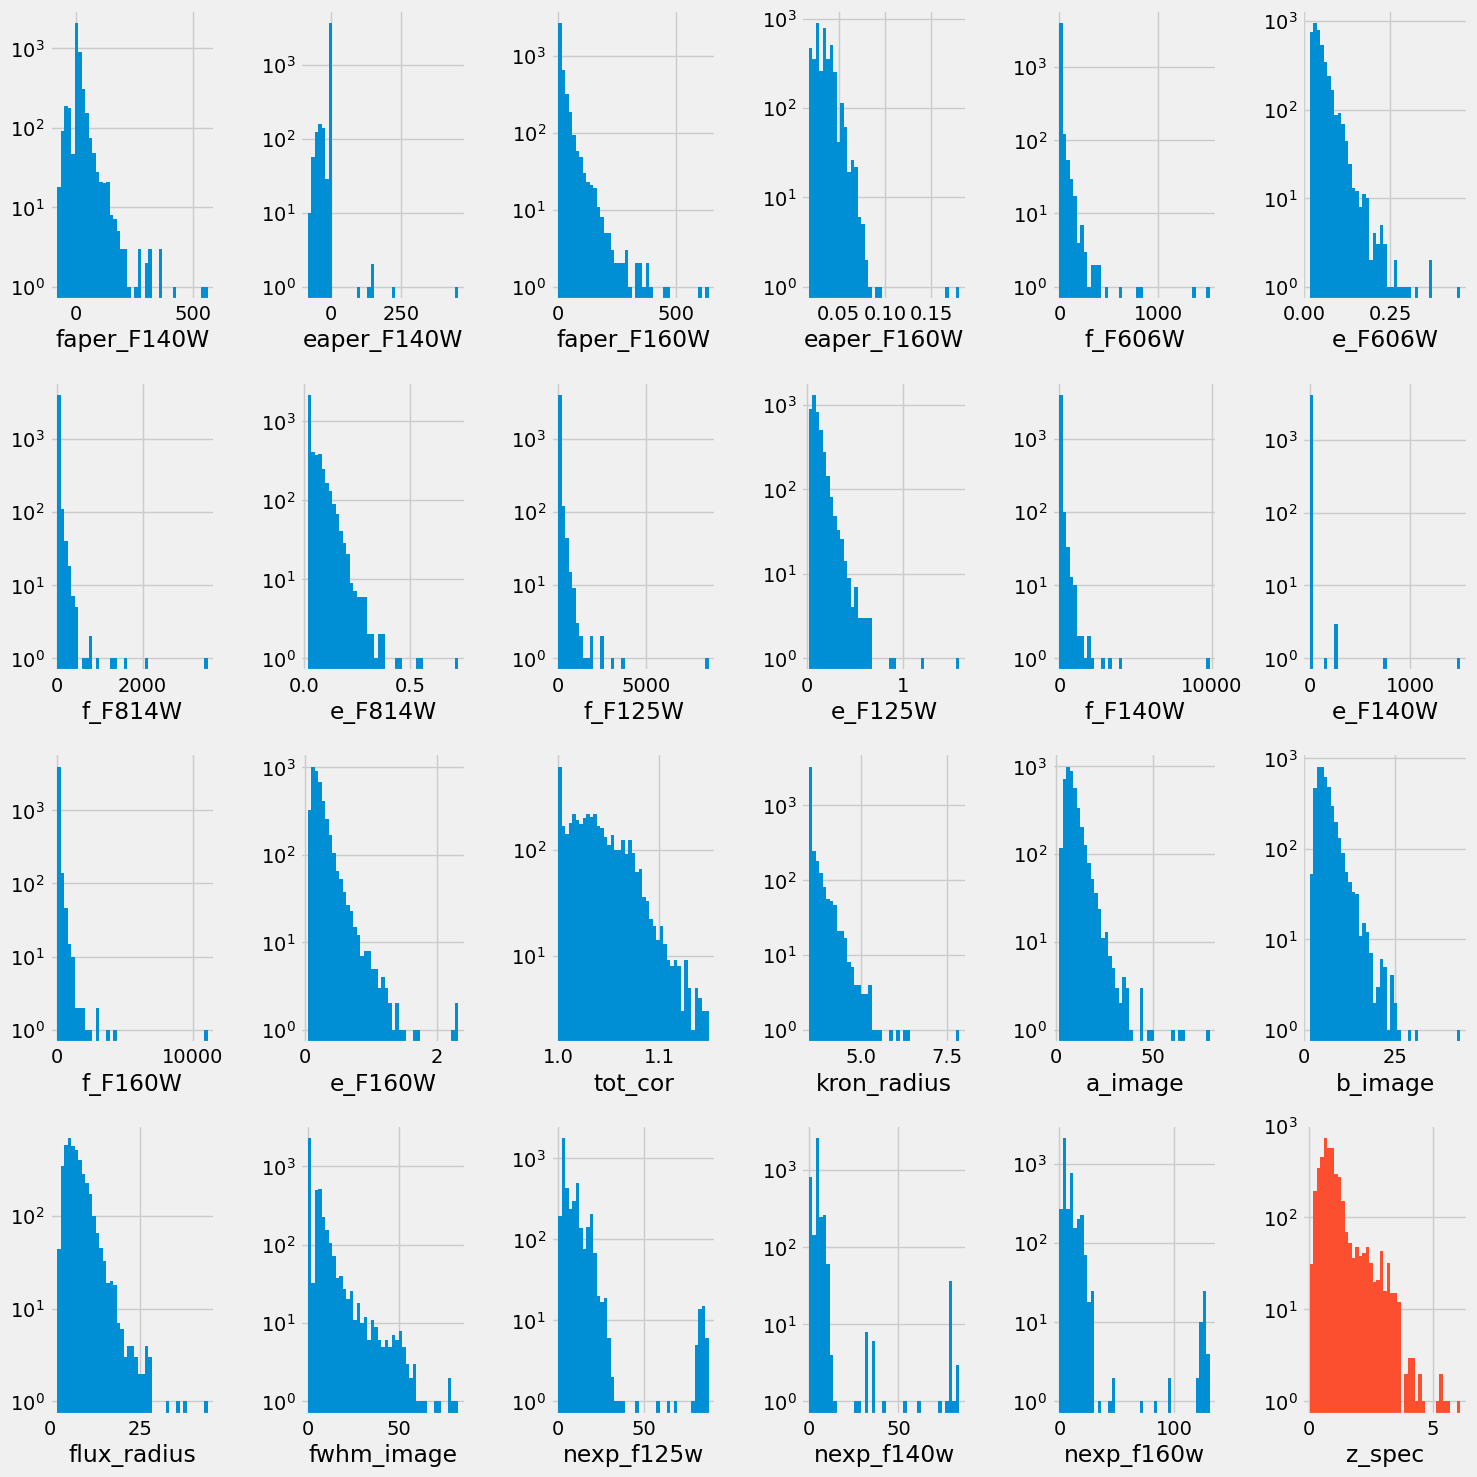

In [17]:
columns = [k for k in df_x.columns]
wrap = 6  # number of columns to show in a row
nlines = (len(columns) + 1) // wrap + int((len(columns) + 1) % wrap > 0)
fig, axs = plt.subplots(nlines, wrap, figsize=(15, 15))
for i, ax in enumerate(axs.ravel()):
    if i >= len(columns):
        ax.axis("off")
        continue
    ax.hist(df_x[columns[i]], bins=43, log=True)
    ax.set_xlabel(columns[i])

ax = axs[-1, -1]
ax.axis("on")
plt.hist(df_y, bins=43, log=True, color="C1")
plt.xlabel("z_spec")
plt.tight_layout()

Markdown("""
> Distribution of all the feature columns we selected and the target (red) after preprocessing.
""")

As we are about to make a linear regression model, we can look into the correlations between all the features and `z_spec` as below.

> Spearman correlation of the selected features and the target spectroscopic redshift.

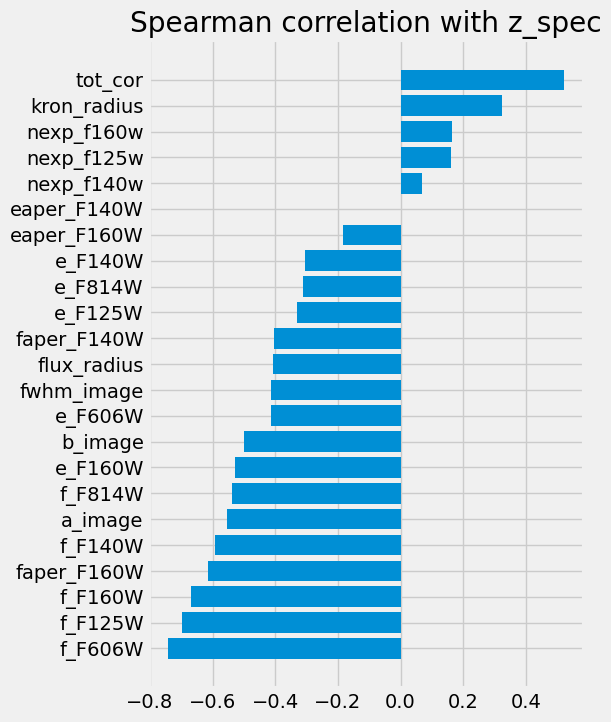

In [18]:
plt.figure(figsize=(5, 8))
corr = df_x.corrwith(df_y, method="spearman")
corr = corr.sort_values()
plt.barh(np.arange(len(corr)), corr, tick_label=corr.index)
plt.title("Spearman correlation with z_spec")
Markdown(
    """> Spearman correlation of the selected features and the target spectroscopic redshift."""
)

These correlations make sense:
* the width of a source indicates that we see the host galaxy, hence a low-redshift source.
* the fluxes link to the photometric redshift, which is when the various lines move from the blue bands to the redder ones.
...

## Building a regression model

In this part, we will use the `scikit-learn` library to build a linear regression model.
(see [scikit-learn documentation](https://scikit-learn.org)
In the next part of the workshop, we will explore models based on neural networks.

### What is machine learning?

In its essence, Machine learning refers to the ability of computer systems to automatically learn and improve from experience without explicit programming. We attribute the foundation of machine learning to Arthur Samuel (see image) who tought a computer how to play checkers in 1959 and to Tom Mitchell who gave it the modern spin in 1997: Machine Learning is the study of computer algorithm that allow computer programs to automatically improve through experience.

![Arthur Samuel](https://mfouesneau.github.io/astro_ds/_images/arthur_samuel.png)
> “Field of study that gives computers the ability to learn without being explicitly programmed.” Arthur Samuel, Teaching a computer to play checkers, 1959 Left is the original black and white image. Right the image processed to infer colors using ML algorithm (colorize-it.com).

Machine learning is part of the grand scheme of automated machine decisions. In computer science, a rule-based system is a system that stores and manipulate knowledge to interpret information or take decisions in a useful way. Normally, the term rule-based system only applies to systems involving human-crafted or curated rule sets. For instance in a factory, if an item is not conforming to the size or shape rule, it will be discarded.

![ai_ml_dl](https://mfouesneau.github.io/astro_ds/_images/AI_ML_DL.png)
> The place and role of AI, ML, and Deep Learning in automated machine decisions. Image adapted from Tukijaaliwa, CC BY-SA 4.0, via Wikimedia Commons, [original source](https://en.wikipedia.org/wiki/File:AI-ML-DL.svg)

If those sets of rules are not explicitly programmed but learned, we enter the domain of artificial intelligence, e.g. automatic rule inference. Artificial intelligence is broad and aims at tackling problems the way humans do. For example, evolutionary algorithms are a family of optimization algorithms inspired by processes of natural evolution. They help to solve complex optimization problems by iteratively improving a population of candidate solutions over multiple generations. 

Finally, we have a category of algorithms that can learn from examples. One could see this category as a family of algorithms that update their code (or parameters) based on a learning process.

![ml_tree](https://mfouesneau.github.io/astro_ds/_images/ml_branch_ai.png)
> Machine learning is only one branch of AI and the learning processes are commonly divided into three categories: supervised, unsupervised, and reinforced learning. Deep learning is a subpart of the machine learning family.

💡 **Summary**
ML is a _"Field of non-trivial data analysis of complicated data sets"_

ML involves
* data description, interpretation
* prediction
* inference, i.e. learning from the data

ML Algorithms
* can extract information from high dimensional data
* find general properties, structures of the data
* we can map those properties to physical interpretation

⚠️ **Machine learning is NOT** A _"~magical~ universal analysis of complicated data sets"_

ML does not provide
* data compilation, and understanding
* scientific interpretation
* critical thinking

ML Algorithms
* Should never remain a black box
* Will **always** return “an” answer

![xkcd_ml](https://imgs.xkcd.com/comics/machine_learning.png)
> Machine learning is the intersection of computer science and mathematics and lacks domain expertise required to properly interpret the outputs. - image source: [xkcd](https://xkcd.com/1838/)


### Scikit learn: a machine learning library for Python

[Scikit-learn](https://scikit-learn.org/stable/) is a free software machine learning library for the Python programming language. It features various classification, regression, and clustering algorithms including support vector machines, random forests, gradient boosting, k-means, and DBSCAN. 

The library itself follows the tree structure above, but also provides tools to preprocess data and analyze the predictions.

Here we explore a few options for regressor models.
You can find all available models on the [sklearn documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

One particular convenience of `sklearn` is its standard API for any model. You can test almost anything with four steps:
* `from sklearn.<path> import Model`
* `model = Model(**parameters)`, where `parameters` will vary from model type to model type.
* `model.fit(X, y)`, the actual _training_ step where `X` is the features and `y` the target.
* `ypred = model.predict(X)`



We will start with a simple linear regression model.
```python
from sklearn.linear_model import LinearRegression
```
But first we need to understand the concepts and proper practice for training a model.

### Concept of training a model

In machine learning, we train a model to learn the relationship between the features and the target variable. The model is trained on a _training dataset_. The model is then used to make predictions on new data.

In machine learning the training set matters gianormously to make our models accurate and performant. To understand it better, I always use the elephant parable:

> _Six blind persons are asked to describe an elephant by touching its body parts. A first one feels its side and describes it as a wall, a second touches its tusk and thinks it is a spear, a third one feels the trunk and confidently identifies a snake, a fourth touches a knee and believes it could be a tree, the fifth palps the ear and thinks of a fan and, finally, a sixth holds the tail and assumes the elephant is a rope._

![elephant](https://mfouesneau.github.io/astro_ds/_images/elephant_train_test.png)

None of the blind people was wrong in their analysis. They plausibly described what they touched and felt. The challenge comes from their limited perception. They each assumed their interaction was representative of the full picture, but they were wrong.

This parable represents exactly what training sets do to machine learning. But often it could be hard to know it’s an elephant, we don’t always have the whole picture to check.

The training set must be sufficiently representative of the whole picture to lead to the right conclusion. If any of the blind people would cross check with another, their conclusions would most likely be different.

### Validating: the "Generalization problem"

How do we know if our model is good? We need to validate it on a _validation dataset_ that was not used to train the model. This is called _validation_.

Validation is an essential step when developing a machine learning model as it ensures that the training set accurately represents what will happen during application deployment. To validate a machine learning model, one should mask part of their training set and use this blind test on their trained algorithm or neural network before deploying into production environment . It’s also important for validation sets not only contain representative elements but also unseen elements so as to properly assess how well your system can adapt given new inputs and scenarios which may occur during its applications.

Validating and testing your algorithms with unseen data helps ensure we created an accurate representation of reality and that we identify any potential issues before they become critical errors down the line.

At its core, **validating ML Model is testing and understanding the limits** of our system’s ability at adapting given new input parameters while still maintaining accuracy throughout all possible scenarios within our application domain. This adaptation is a **generalization problem**.

💡 **Training, testing, applying: the three inevitable ones**

* **Training**: Giving (labeled or unlabeled) data to your method and letting it find a mapping between input and output variables.

* **Testing**: Using a new piece of data to check the mapping works outside the training. Determines performance of the model.

* **Applying**: Applying to a dataset that is neither trained or tested on, for which the “correct” answer is unknown.

* **Generalizing**: Enabling applications to other “domains” (e.g. extrapolating).


In [19]:
from sklearn.model_selection import train_test_split

# first reserve 70% of the data for training, 30% for validation
X_train, X_validate, y_train, y_validate = train_test_split(
    df_x, df_y, test_size=0.3, random_state=42
)

# second, split the validation set in half to obtain validation and test sets.
X_validate, X_test, y_validate, y_test = train_test_split(
    X_validate, y_validate, test_size=0.5, random_state=42
)

Note that sklearn plays nice with Pandas dataframes, so we can directly use the `df` dataframe we created earlier. The splitting of the data preserves the indices and structure of the dataframe(s).

In [20]:
X_train

,faper_F140W,eaper_F140W,faper_F160W,eaper_F160W,f_F606W,e_F606W,f_F814W,e_F814W,f_F125W,e_F125W,...,e_F160W,tot_cor,kron_radius,a_image,b_image,flux_radius,fwhm_image,nexp_f125w,nexp_f140w,nexp_f160w
29025,6.4002,0.071377,7.2190,0.035512,3.3954,0.026409,4.2290,0.039645,8.0038,0.064372,...,0.094426,1.0835,3.50,4.250,3.290,3.70,0.00,3,4,4
98836,27.4130,0.062185,31.9470,0.027046,2.6742,0.037497,3.6540,0.029913,60.7920,0.054009,...,0.297310,1.0000,3.50,13.420,11.381,8.84,5.93,11,4,11
191338,33.9540,0.107990,41.0830,0.032563,4.2636,0.030712,16.8430,0.030772,43.4220,0.101360,...,0.164630,1.0460,3.50,6.282,4.883,3.80,5.17,4,8,4
97780,7.9320,0.055473,9.0406,0.025325,2.5421,0.028033,3.6540,0.029913,14.1130,0.038465,...,0.104510,1.0520,3.50,6.980,3.909,5.59,0.00,12,5,12
114776,14.6570,0.089442,15.2220,0.045612,24.7070,0.046624,34.9960,0.058258,47.5500,0.315300,...,0.380120,1.0140,3.50,9.141,7.513,9.06,15.51,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139473,12.5330,0.090548,13.8190,0.020648,6.9577,0.030069,14.2580,0.027619,25.0290,0.101630,...,0.122980,1.0337,3.50,7.278,5.495,6.32,8.36,20,4,20
21350,33.9850,0.069030,40.7520,0.035518,14.6320,0.090648,44.0510,0.132970,107.5900,0.148460,...,0.352670,1.0016,3.50,11.520,9.660,11.20,5.93,4,4,4
122753,5.6064,0.065174,1.8982,0.022502,1.9485,0.043585,3.3442,0.030137,4.9569,0.123690,...,0.133770,1.0338,4.00,6.175,4.943,7.13,0.00,18,0,18
150310,9.2998,0.080835,11.3270,0.018117,2.3404,0.025502,6.4228,0.028524,14.9440,0.073691,...,0.088624,1.0476,3.50,7.030,4.130,5.39,11.04,17,4,17


### Linear Regression Model

Let's do a simple one first

In [21]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()

**How do we quantify the performance of our model?**

To quantify the performance of the model, we will apply it to the validation set and compare the predicted values with the true values by computing the mean squared error (MSE). Again sklear has you covered!

```python
from sklearn.metrics import mean_squared_error
```


> The prediction of the redshifts using a linear regression model. The model is not very good, the MSE = 0.2745, but it's a start.
We can see that the model is not very good at predicting redshifts, especially for high redshifts where the bias is significant.

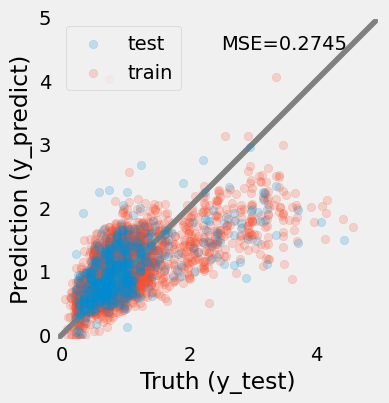

In [22]:
from sklearn.metrics import mean_squared_error

y_predict = lin.predict(X_test)
y_predict0 = lin.predict(X_train)
mse = mean_squared_error(y_test, y_predict)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label="test")
ax.scatter(y_train, y_predict0, alpha=0.2, label="train", zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color="0.5")
ax.set_aspect("equal")
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel("Truth (y_test)")
ax.set_ylabel("Prediction (y_predict)")
plt.legend(loc="upper left")
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha="right")
Markdown(f"""
> The prediction of the redshifts using a linear regression model. The model is not very good, the MSE = {mse:.4f}, but it's a start.
We can see that the model is not very good at predicting redshifts, especially for high redshifts where the bias is significant.""")

This plot shows that the linear regression model is getting the bulk of the data but performs poorly when the data becomes sparse, i.e. $z > 1.5$.

How do we know which features drive the prediction?

We can look at the coefficients of each feature from the model using the  `LinearRegression.coef_` attribute.

 > Coefficients of the linear model sorted by values.

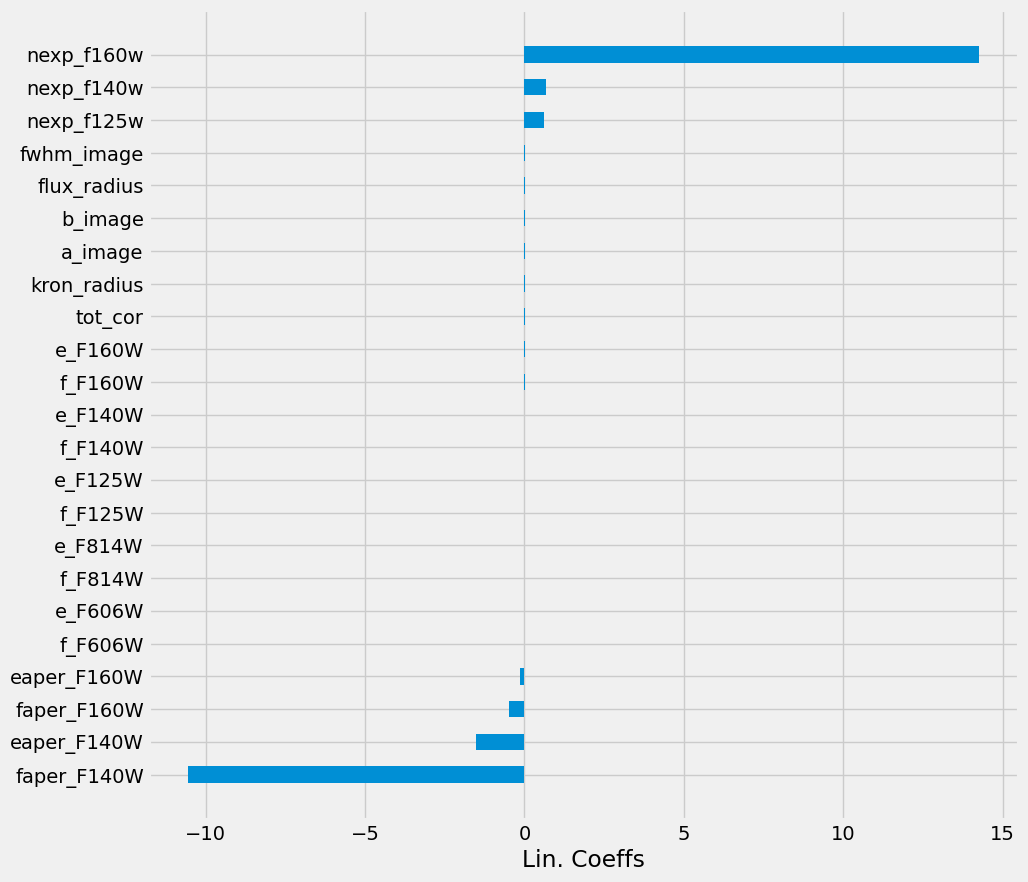

In [23]:
importances = lin.coef_
labels = lin.feature_names_in_
# older version: labels = df_x.columns
argsort = np.argsort(importances)
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
ax.barh(
    np.arange(len(df_x.columns)),
    importances[argsort],
    align="center",
    height=0.5,
    tick_label=labels,
)
ax.set_xlabel("Lin. Coeffs")
Markdown(""" > Coefficients of the linear model sorted by values.""")

However, note here that we have features with very different dynamical ranges. Hence comparing feature amplitudes does not reflect how important these are for the model. One would need to normalize the dimensions first. (We do so in the next model.)

Overall the MSE is not great. Not surprising given the simplicity of our model. Maybe we can do better by changing it?

What simple model could we try next?

#### Polynomial regression model

In this section, we explore a polynomial model. Such a model takes an input feature vector $X=(a, b)$ and turns it into $X^\prime=(1, a, b, a^2, b^2, a\cdot b)$ for a degree=2 polynomial.

see `sklearn.preprocessing.PolynomialFeatures`

To make this modeling more robust, we will also normalize the data. We will use 

see `sklearn.preprocessing.StandardScaler`

We will also switch from a traditional linear regression to a **regularized** regression. This regularization is one or multiple additional terms in the loss function that penalizes the number of non-null coefficients. 

see for example: `sklearn.linear_model.LassoLars`, `sklearn.linear_model.ElasticNet`

In the following we use `sklearn.linear_model.LassoLarsIC`, a lasso model fit with Lars using BIC or AIC for model selection (setting how strong the penalization should be).

Our training flow is then:
1. We first create the polynomial features
2. We then normalize the data
3. We fit the model

And we need to keep track of our transformations to apply them to the validation set (or any new data). Luckily, `sklearn` has a `Pipeline` object that chains transformations and models.

```python
from sklearn.pipeline import Pipeline
```

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoLarsIC

pipe = Pipeline(
    [
        ("polynomial", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler()),
        ("classifier", LassoLarsIC()),
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('scaler', StandardScaler()), ('classifier', LassoLarsIC())])

In the above, we also use `Pipeline`, which is a convenient wrapper around sequential steps:
here, we expand `X_train` to a polynomial of degree=2, then standardize the data before applying the regressor. `Pipeline` is an object that understands the API and knows which functions to call for each step.

Manually, the `pipe.fit` would be something like
```python
Xprime = polynomial.fit_transform(X_train)
Xscaled = scaler.fit_transform(Xprime)
classifier.fit(X_train, y_train)
```

Then to predict values, similar steps would be necessary
```python
Xprime = polynomial.transform(X_test)
Xscaled = scaler.fit_transform(Xprime)
ypred = classifier.fit(X_test, y_test)
```
but `pipe.predict` is more convenient.

**How does the model perform?**



> The prediction of the redshifts using a polynomial regression model (degree=2). The model is still not very good, the MSE = 0.2163.
The bias at high redshits remains significant.

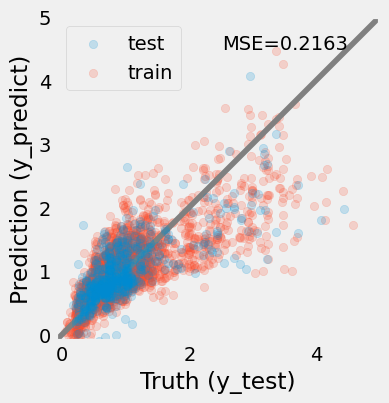

In [25]:
# This is the same code as above
y_predict = pipe.predict(X_test)
y_predict0 = pipe.predict(X_train)
mse = mean_squared_error(y_test, y_predict)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label="test")
ax.scatter(y_train, y_predict0, alpha=0.2, label="train", zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color="0.5")
ax.set_aspect("equal")
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel("Truth (y_test)")
ax.set_ylabel("Prediction (y_predict)")
plt.legend(loc="best")
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha="right")
Markdown(f"""
> The prediction of the redshifts using a polynomial regression model (degree={pipe['polynomial'].degree}). The model is still not very good, the MSE = {mse:.4f}.
The bias at high redshits remains significant.""")

The results look better (MSE shows ~20% improvement). The $z > 1.5$ looks closer to the identity line, but still not perfect.

**Which features are important?**

```python
pipe['classifier'].coef_
```

 > Coefficients of the polynomial model sorted by absolute values. The regularization has set many of the coefficients to zero that we do not represent here.

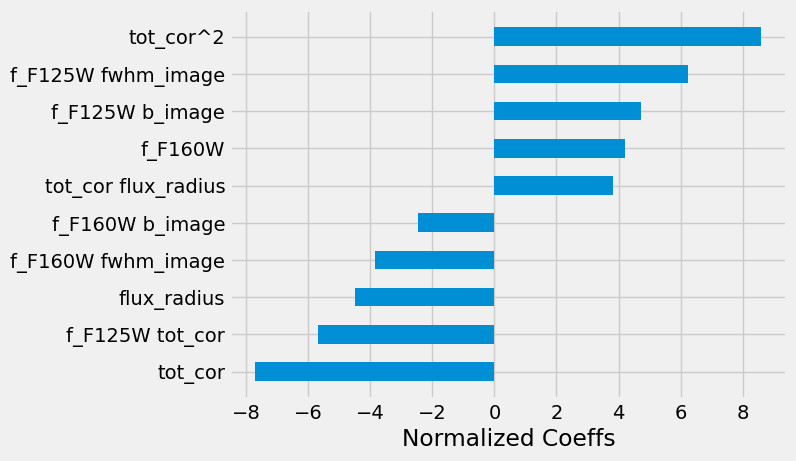

In [26]:
importances = pipe["classifier"].coef_
labels = pipe["polynomial"].get_feature_names_out()
# older version: labels = df_x.columns
argsort = np.argsort(np.abs(importances))  # absolute importance

show_n = 10
argsort = argsort[-show_n:]
importances = importances[argsort]
labels = labels[argsort]
argsort = np.argsort(importances)  # for aesthetic

plt.figure()
ax = plt.subplot(111)
ax.barh(
    np.arange(len(labels)),
    importances[argsort],
    align="center",
    height=0.5,
    tick_label=labels[argsort],
)
ax.set_xlabel("Normalized Coeffs")

Markdown(
    """ > Coefficients of the polynomial model sorted by absolute values. The regularization has set many of the coefficients to zero that we do not represent here."""
)

Interestingly, the model selected features that are fluxes multiplied by full-width-half-maximum (fwhm) of the image. This is not totally surprising as the fwhm is a proxy for the size of the source, which is a proxy for the redshift.

The residuals of our linear regression models are not great. We can explore other kinds of models.
Changing the degree of the polynomial could help, or the regularization. Eventually, linear models do not seem to be the best fit for this problem.

Using sklearn, we can easily test different models. In particular, we can use non-linear ones.

### Exploring models

#### Random Forest

Using sklearn, we can very easily construct a decision tree model for regressing redshift from the photometric catalog features. A decision tree is composed of a series of if-else decision steps. The number of steps and the types of decision at each step is determined by training the algorithm with supervision. In this first example, we will use the DecisionTreeRegressor from sklearn.

```python
from sklearn.ensemble import RandomForestRegressor
```


In [27]:
from sklearn.ensemble import RandomForestRegressor

# use the same parameters as the Decision Tree

# Initialize the model
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

RandomForestRegressor()


> The prediction of the redshifts using a random forest model . The model improves significantly compared with the previous attemps, MSE = 0.1188.
The bias at high redshits may remains but it is significantly reduced.

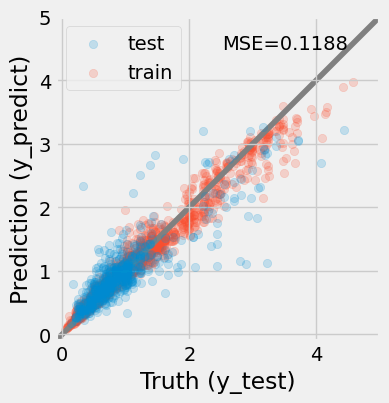

In [28]:
y_predict = rf.predict(X_test)
y_predict0 = rf.predict(X_train)
mse = mean_squared_error(y_test, y_predict)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_test, y_predict, alpha=0.2, label="test")
ax.scatter(y_train, y_predict0, alpha=0.2, label="train", zorder=-1)
ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color="0.5")
ax.set_aspect("equal")
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.set_xlabel("Truth (y_test)")
ax.set_ylabel("Prediction (y_predict)")
plt.legend(loc="best")
ax.text(0.9, 0.9, f"MSE={mse:0.4f}", transform=ax.transAxes, ha="right")
Markdown(f"""
> The prediction of the redshifts using a random forest model . The model improves significantly compared with the previous attemps, MSE = {mse:.4f}.
The bias at high redshits may remains but it is significantly reduced.""")

The results are much improved by the random forest! 

However, we must be cautious. It is possible that this model suffers from **over-fitting**. 

#### Bias, Variance, Over-fitting, and Under-fitting

Overfitting is a common problem in machine learning, where a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.

 > Example of under/over-fitting using polynomial regression with different degrees. The model with degree 2 is underfitting, and degree 10 is overfitting the data.

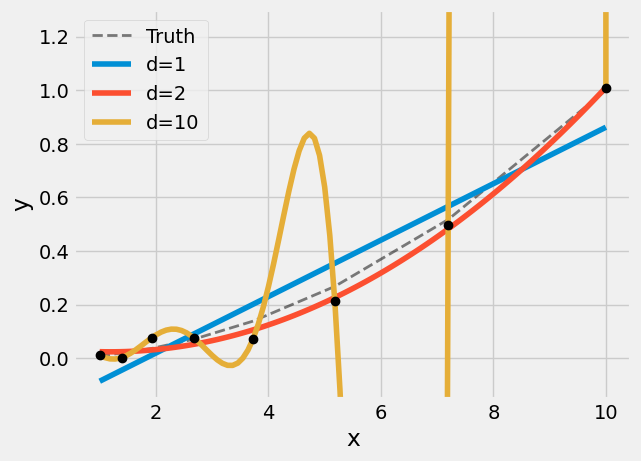

In [29]:
x = np.logspace(0, 1, 8)
ytrue = (x / 10) ** 2
y = ytrue + np.random.randn(len(x)) * 0.05
plt.plot(x, ytrue, "k", ls="--", alpha=0.5, lw=2, label="Truth")
plt.plot(x, y, "ko", zorder=100)

x_eval = np.linspace(x.min(), x.max(), 100)
for degree in [1, 2, 10]:
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(x[:, None])
    X_eval = poly.transform(x_eval[:, None])
    preds = LinearRegression().fit(X, y).predict(X_eval)
    plt.plot(x_eval, preds, label=f"d={degree}")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-0.15, 1.3)
plt.legend()

Markdown(
    """ > Example of under/over-fitting using polynomial regression with different degrees. The model with degree 2 is underfitting, and degree 10 is overfitting the data."""
)

In the above figure, we see polynomial fits for three different degrees $d$. 

* $d = 1$, the model **underfit**, the model is too simplistic, and overall predictions will be inaccurate. This model suffers from **bias**. The reason for this label is that the model makes strong assumptions about the form of the underlying function that maps inputs to outputs.
* $d = 10$, the model **overfit**, the model is too flexible (has too many free parameters) it can pass through the training data perfectly. But any new data will be terribly predicted. This model suffers from **high variance**: any small update of one $(x, y)$ will lead to an extremely different model.
* $d = 2$, the model is **just right** (duh!). It captures the underlying trend of the data, but is not too flexible. This model has a good balance between bias and variance.


To visualize overfitting, we can compare the mean squared error (MSE) for models of increasing `max_depth` on the training and testing sets.

💡 Lucky for us that our model here is fast to train. In some cases, exploring values for the model's parameters can become extremely expensive.

In [30]:
# Implementation that shows an example of
# parallel processing with joblib (installed with sklearn)
from joblib import delayed, Parallel


def compute_mse(max_depth, X_train, y_train, X_test, y_test):
    params = {
        "min_samples_split": 15,
        "min_samples_leaf": 5,
    }
    rf = RandomForestRegressor(max_depth=max_depth, **params)
    rf.fit(X_train, y_train)

    y_predict_train = rf.predict(X_train)
    y_predict_test = rf.predict(X_test)

    mse_values = (
        max_depth,
        mean_squared_error(y_train, y_predict_train),
        mean_squared_error(y_test, y_predict_test),
    )
    return mse_values


max_depths = np.arange(1, 20, 2).astype(int)

results = Parallel(n_jobs=-1)(
    delayed(compute_mse)(depth, X_train, y_train, X_test, y_test)
    for depth in max_depths
)


> The MSE for the training and test sets as a function of the maximum depth of the trees in the random forest model.
The model is overfitting for depths greater than 10, as the test error diverges from the train error.
At low depths, the model is underfitting, and the error is high for both sets.

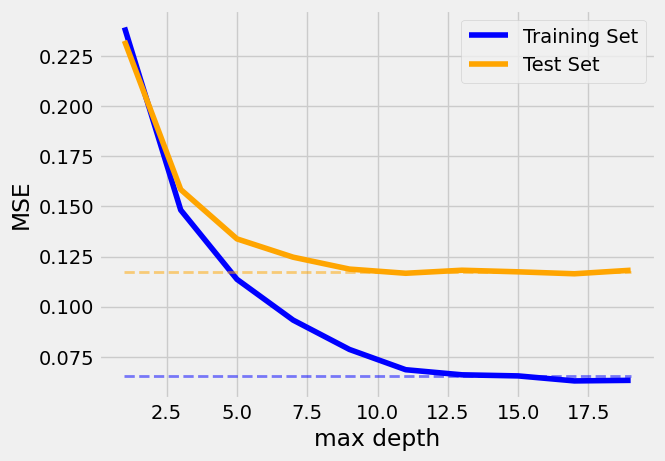

In [31]:
results = np.array(results)

fig, ax = plt.subplots(1, 1)

ax.plot(results[:, 0], results[:, 1], color="blue", label="Training Set")
ax.plot(results[:, 0], results[:, 2], color="orange", label="Test Set")

final_interval = results[:, 0] >= 10.0
ax.hlines(
    [results[final_interval, 1].mean()],
    xmin=results[:, 0].min(),
    xmax=results[:, 0].max(),
    color="blue",
    alpha=0.5,
    linestyle="--",
    lw=2,
)
ax.hlines(
    [results[final_interval, 2].mean()],
    xmin=results[:, 0].min(),
    xmax=results[:, 0].max(),
    color="orange",
    alpha=0.5,
    linestyle="--",
    lw=2,
)

ax.set_xlabel("max depth")
ax.set_ylabel("MSE")
ax.legend()
Markdown("""
> The MSE for the training and test sets as a function of the maximum depth of the trees in the random forest model.
The model is overfitting for depths greater than 10, as the test error diverges from the train error.
At low depths, the model is underfitting, and the error is high for both sets.""")

Beyond a max_depth of ~10, the MSE on the training set declines while the MSE on the test set flattens out, suggesting some amount of over-fitting: the flattening indicates that the model does not learn anything more from the data, so we can stop the complexity early.

Note that sometimes, the residuals could increase again on the test set.

#### Cross-validation

To explore further, we will explore how general our model performance (here quantifed with MSE) is using k-fold cross-validation via sklearn. In practice, the X and y datasets are split into k “folds”, and over k iterations, the model is trained using k-1 folds as training data and the remaining fold as a test set to compute performace (i.e., MSE).

```python
from sklearn.model_selection import cross_validate
```

In [32]:
from sklearn.model_selection import cross_validate

cv = cross_validate(
    estimator=rf,
    X=df_x,
    y=df_y,
    cv=5,  # number of folds
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

print(
    f'Cross-validated MSE score: {-cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}'
)

Cross-validated MSE score: 0.139 +/- 0.051


💡 We used the full data set with known labels because the cross-validation procedure sets a train and test set at every fold.

The previous MSE is consistent with the cross-validated MSE, suggesting that the model is not significantly over-fitting.

#### Feature importance

Next, we’ll observe which features are most important to the model predictions. Note that as trees implements selections per dimensions, a normalization of the data is not necessary.

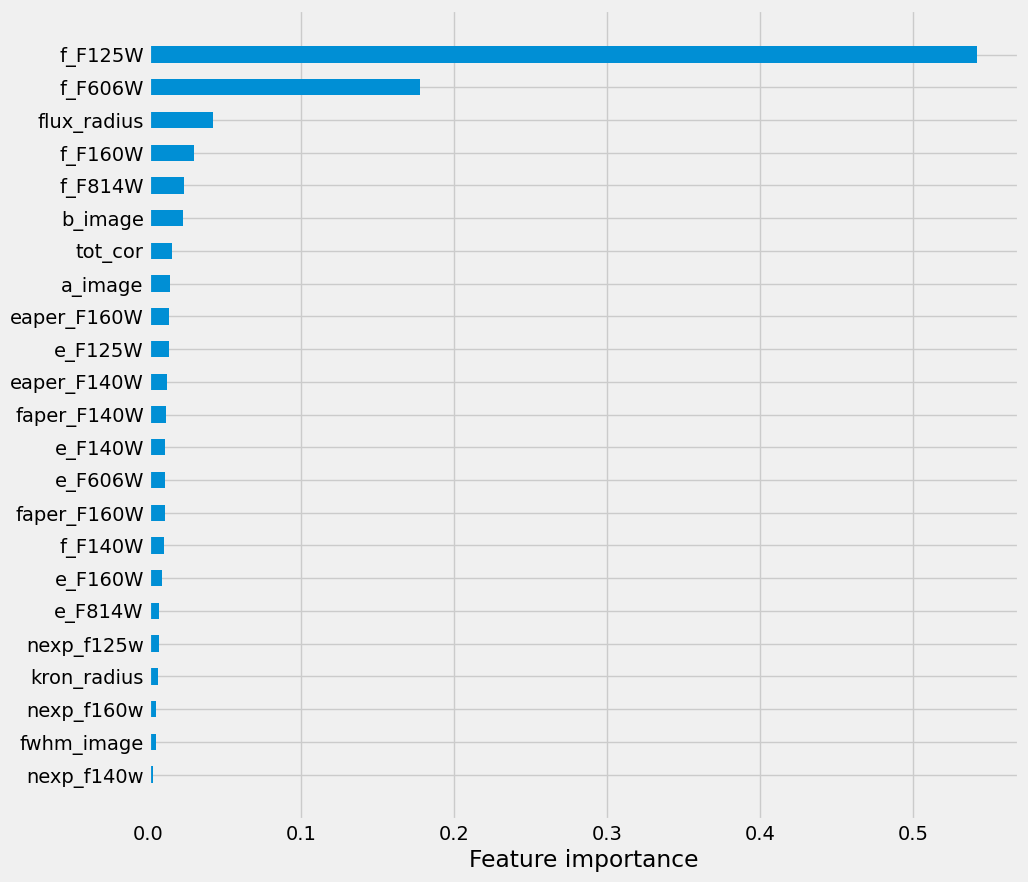

In [33]:
# plot we did before
importances = rf.feature_importances_
argsort = np.argsort(importances)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)
ax.barh(
    np.arange(len(df_x.columns)),
    importances[argsort],
    align="center",
    height=0.5,
    tick_label=np.array(features)[argsort],
)
ax.set_xlabel("Feature importance");

We see that basically our model is by a few bands (F606, F814W, F160W, F125W) and the width of the aperture.

**⚠️ Warning**: the feature importance in trees is not robust due to the manner they are build (see also sklearn documentation). In practice, these are indicative, but if you need a proper characterization, you will need something like the SHAP values (SHapley Additive exPlanations), e.g. [SHAP package](https://shap.readthedocs.io/en/latest/index.html).

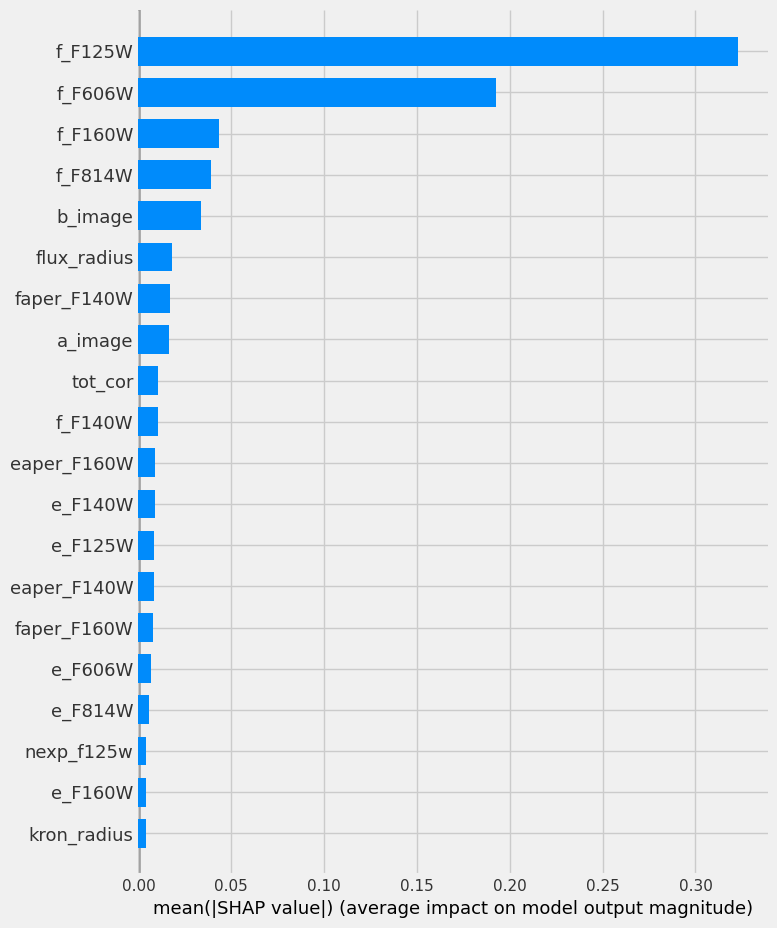

In [34]:
import shap

shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

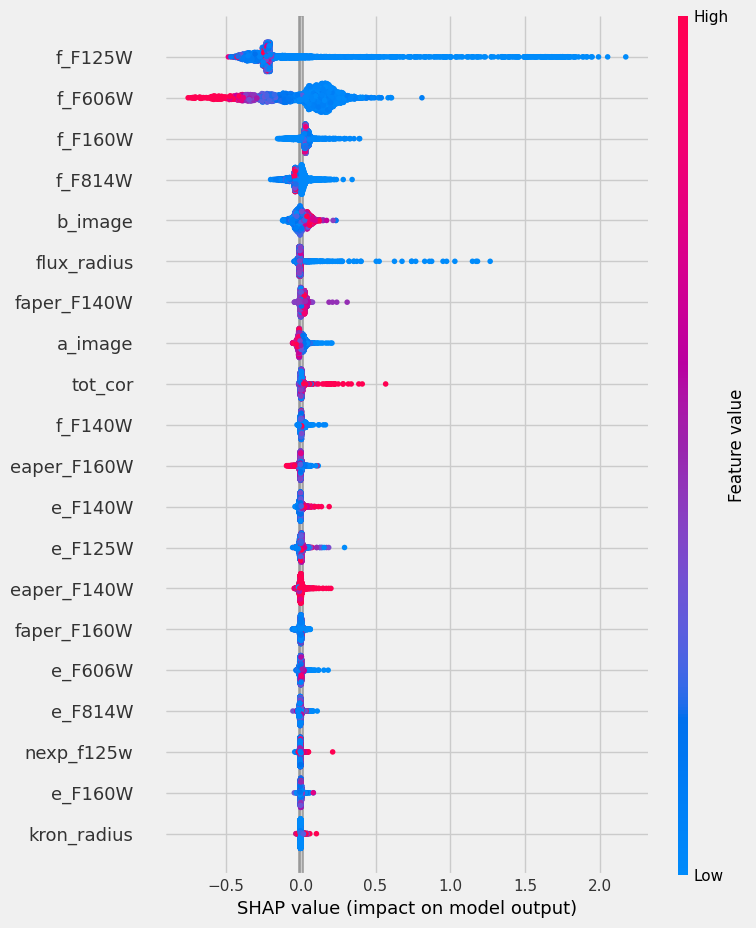

In [35]:
import matplotlib.pyplot as plt

f = plt.figure()
shap.summary_plot(shap_values, X_train)

SHAP values are expensive to compute, these are equivalent to a leave-one-out procedure on each feature.
However, they also provide more insight into what information pieces are relevant to the model.

#### Other models

In this section, we explore any interesting model that sklearn provides (e.g. `lighGBM`, `HistGradientBoostingRegressor`). We will train the models and compare their performance based on the root-MSE metric and diagnostic plots.

In [36]:
from sklearn.ensemble import HistGradientBoostingRegressor


et = HistGradientBoostingRegressor()
et.fit(X_train, y_train)

pipe2 = Pipeline(
    [
        ("polynomial", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler()),
        ("classifier", HistGradientBoostingRegressor()),
    ]
)

pipe2.fit(X_train, y_train);

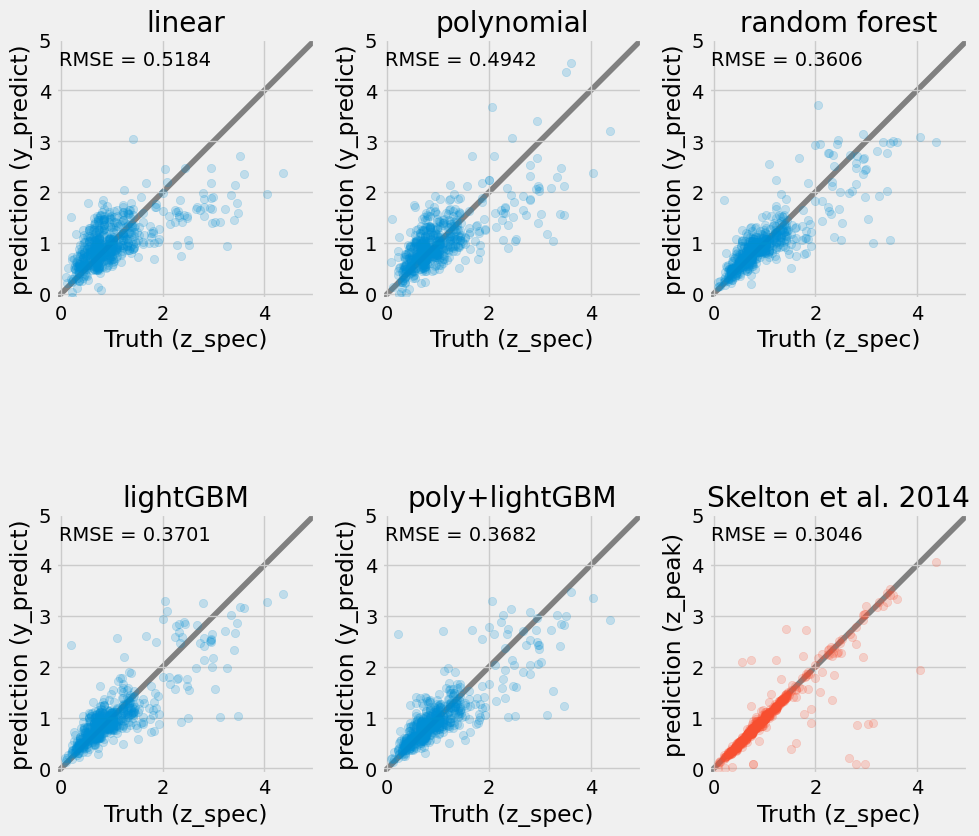

In [39]:
from sklearn.metrics import root_mean_squared_error

y_values = [
    lin.predict(X_validate),
    pipe.predict(X_validate),
    rf.predict(X_validate),
    et.predict(X_validate),
    pipe2.predict(X_validate),
    df["z_peak"].loc[X_validate.index],
]

yp_train = [
    lin.predict(X_train),
    pipe.predict(X_train),
    rf.predict(X_train),
    et.predict(X_train),
    pipe2.predict(X_train),
    df["z_peak"].loc[X_train.index],
]

names = [
    "linear",
    "polynomial",
    "random forest",
    "lightGBM",
    "poly+lightGBM",
    "Skelton et al. 2014",
]


fig, ax = plt.subplots(2, len(names) // 2, figsize=(10, 10))

for k, (ax, ypt, yval) in enumerate(zip(np.ravel(ax), yp_train, y_values)):
    color = None
    if k == len(names) - 1:
        color = "C3"
    ax.scatter(y_train, ypt, alpha=0.2, color=color)
    ax.scatter(y_validate, yval, alpha=0.2, color=color)
    ax.set_aspect("equal")
    ax.set_xlim(-0.1, 5)
    ax.set_ylim(-0.1, 5)
    ax.plot(ax.get_xlim(), ax.get_xlim(), zorder=-1, color="0.5")
    ax.set_xlabel("Truth (z_spec)")
    ax.set_ylabel("prediction (y_predict)")
    ax.set_title(names[k])
    mse = root_mean_squared_error(y_validate, yval)
    ax.text(0.01, 0.9, f"RMSE = {mse:.4f}", transform=ax.transAxes)

ax = plt.gcf().get_axes()[-1].set_ylabel("prediction (z_peak)")

plt.tight_layout()

### Going further

* What if you include galaxy colors (e.g., F125W-F140W, F140W-F160W, F606W-F125W)? do the model results improve? Can you think of other features to include?

* Can you tune the model parameters with a grid search? 

* What if you try other models from sklearn?